# Datasets Description

This notebook is to make sure anyone can produce the **exactly** same dataset used in the paper

Please see http://astronn.readthedocs.io/en/latest/quick_start.html#folder-structure-for-astronn-apogee-and-gaia-data
to setup the enviroment such that astroNN can download SDSS APOGEE data to your computer and compile the dataset

In [1]:
from astroNN.datasets import H5Compiler
from astroNN.apogee import allstar
from astropy.io import fits
import numpy as np

# To create a astroNN compiler instance
compiler = H5Compiler()
compiler.teff_low = 4000  # Effective Temperature Upper
compiler.teff_high = 5500  # Effective Temperature Lower
compiler.vscattercut = 1  # Velocity Scattering Upper
compiler.starflagcut = True  # STARFLAG == 0
compiler.aspcapflagcut = True  # ASPCAPFALG == 0
compiler.ironlow = -10000.  # [Fe/H] Lower
compiler.SNR_low = 200  # SNR Lower
compiler.SNR_high = 99999  # SNR Upper

# allstar file
hdulist = fits.open(allstar(dr=14))

# idx refers to the indices in allstar(dr=14)
idx = compiler.filter_apogeeid_list(hdulist)

compiler.filename = '__train'

# To compile a .h5 datasets, use .compile() method
compiler.compile()

C:\Users\Henry\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Total Combined Spectra after filtering:  33407
Total Individual Visit Spectra there:  98596
-2.4866276
0.57220936


0.7503258001970694


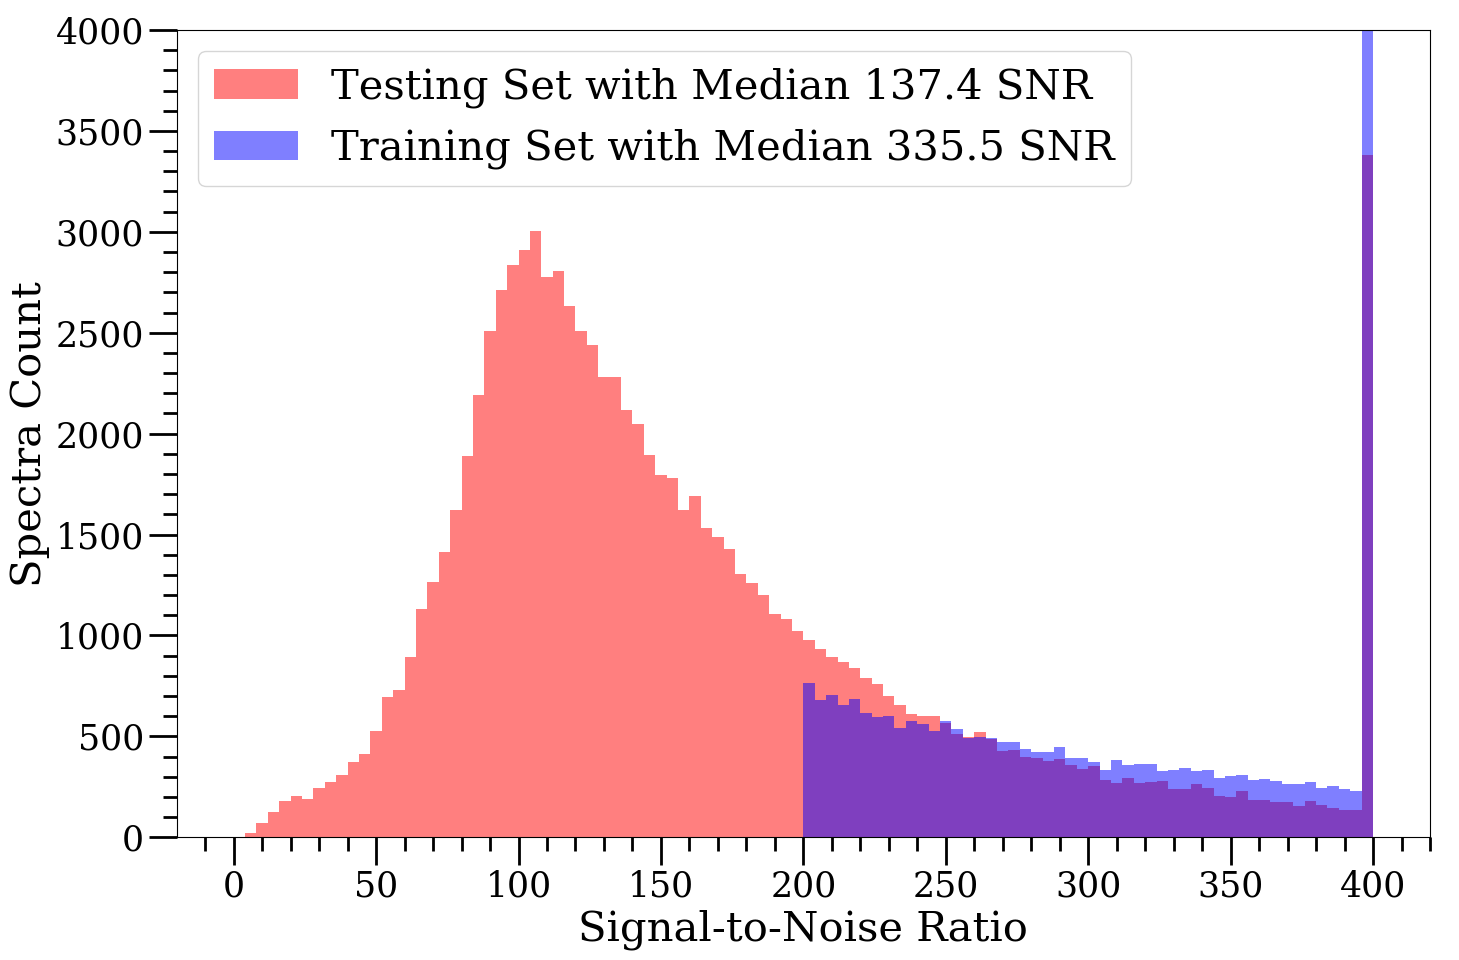

In [2]:
from astroNN.datasets import H5Loader
import pylab as plt
import numpy as np

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
loader = H5Loader('__train')
loader.load_err = False
loader.load_combined = True  # load combined spectra
SNR_train = loader.load_entry('SNR')

loader2 = H5Loader('__train')
loader2.load_err = False
loader2.load_combined = False
SNR_test = loader2.load_entry('SNR')

print(np.where(SNR_test < 200)[0].shape[0] / SNR_test.shape[0])

upper_bound = 400

SNR_test_plot = np.array(SNR_test)
SNR_train_plot = np.array(SNR_train)
SNR_test_plot[(SNR_test>upper_bound)] = upper_bound
SNR_train_plot[(SNR_train>upper_bound)] = upper_bound

plt.figure(figsize=(15,10), dpi=100)
plt.hist(SNR_test_plot, 100, range=(0, 400), facecolor='red', alpha=0.5, label=f'Testing Set with Median {np.median(SNR_test):.{1}f} SNR')
plt.hist(SNR_train_plot, 50, range=(200, 400), facecolor='blue', alpha=0.5, label=f'Training Set with Median {np.median(SNR_train):.{1}f} SNR')
plt.xlabel('Signal-to-Noise Ratio', fontsize=30)
plt.ylabel('Spectra Count', fontsize=30)
plt.ylim((0, 4000))
plt.legend(loc='best', fontsize=30)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
plt.tight_layout()
plt.savefig('SNR.png')
plt.show()

995  of the log(g) are -9999.


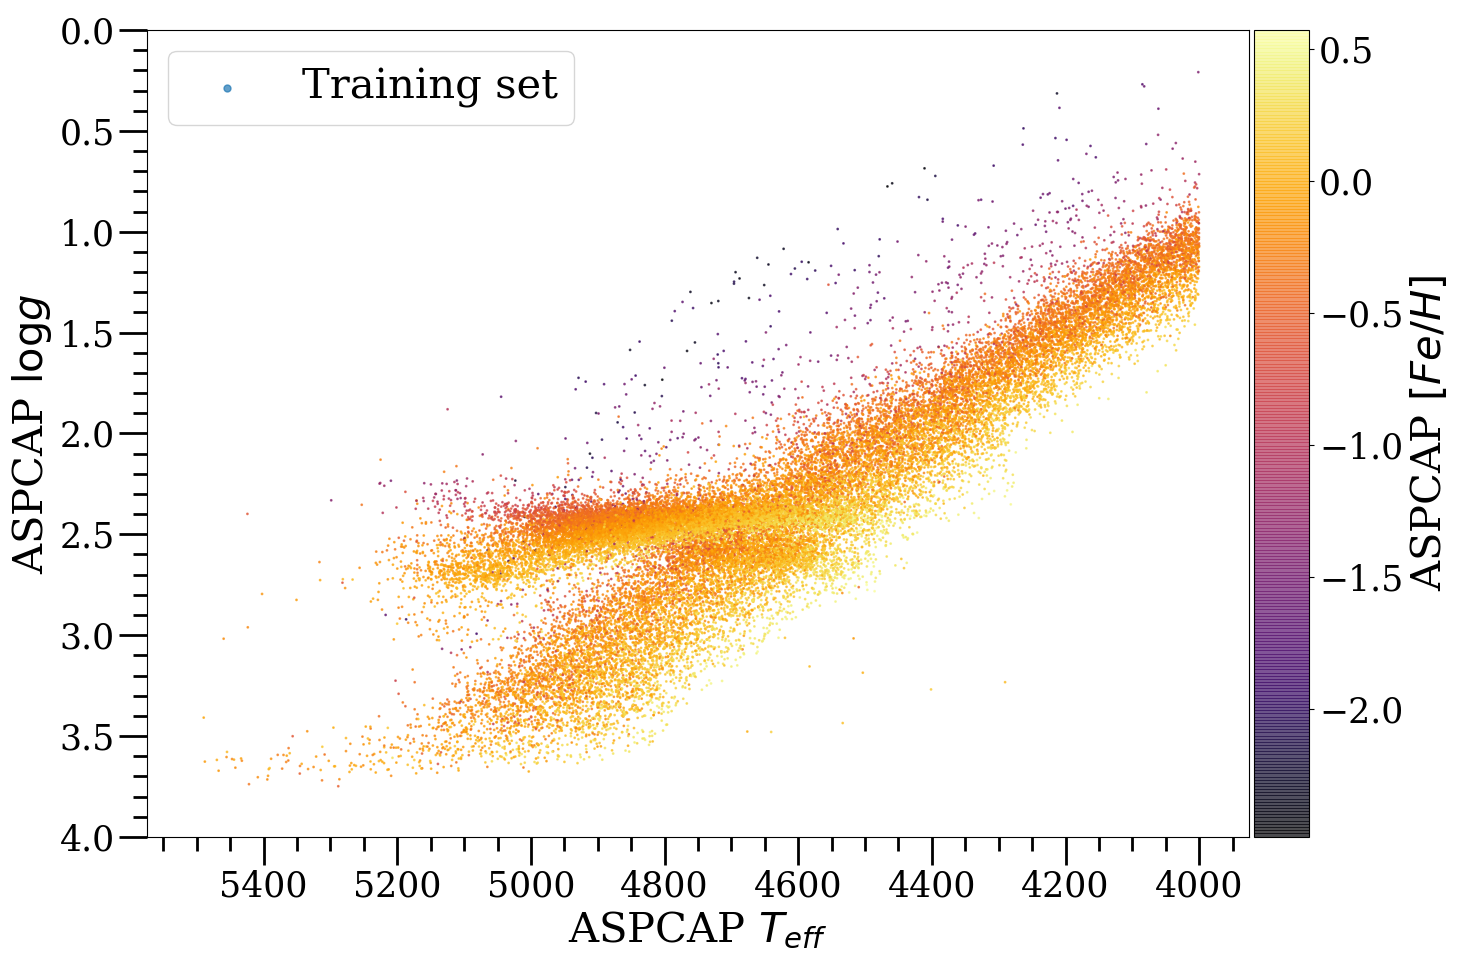

In [2]:
from astroNN.datasets import H5Loader
import pylab as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

loader = H5Loader('__train')
loader.load_err = False
loader.load_combined = True  # load combined spectra
TEFF = loader.load_entry('teff')
LOGG = loader.load_entry('logg')
FE = loader.load_entry('Fe')

print(np.sum([LOGG==-9999]), " of the log(g) are -9999.")

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(TEFF, LOGG, s=1, c=FE, label=f'Training set', alpha=0.7, cmap='inferno')
plt.xlabel('ASPCAP ' +"$T_{eff}$", fontsize=30)
plt.ylabel('ASPCAP '+'$\log{g}$', fontsize=30)
plt.ylim((0., 4.))
plt.legend(loc='best', fontsize=30, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label("ASPCAP "+"$[Fe/H]$", size=30)
            
plt.tight_layout()
plt.savefig('logg_teff_fe.png')
plt.show()

dr is not provided, using default dr=14
dr is not provided, using default dr=14


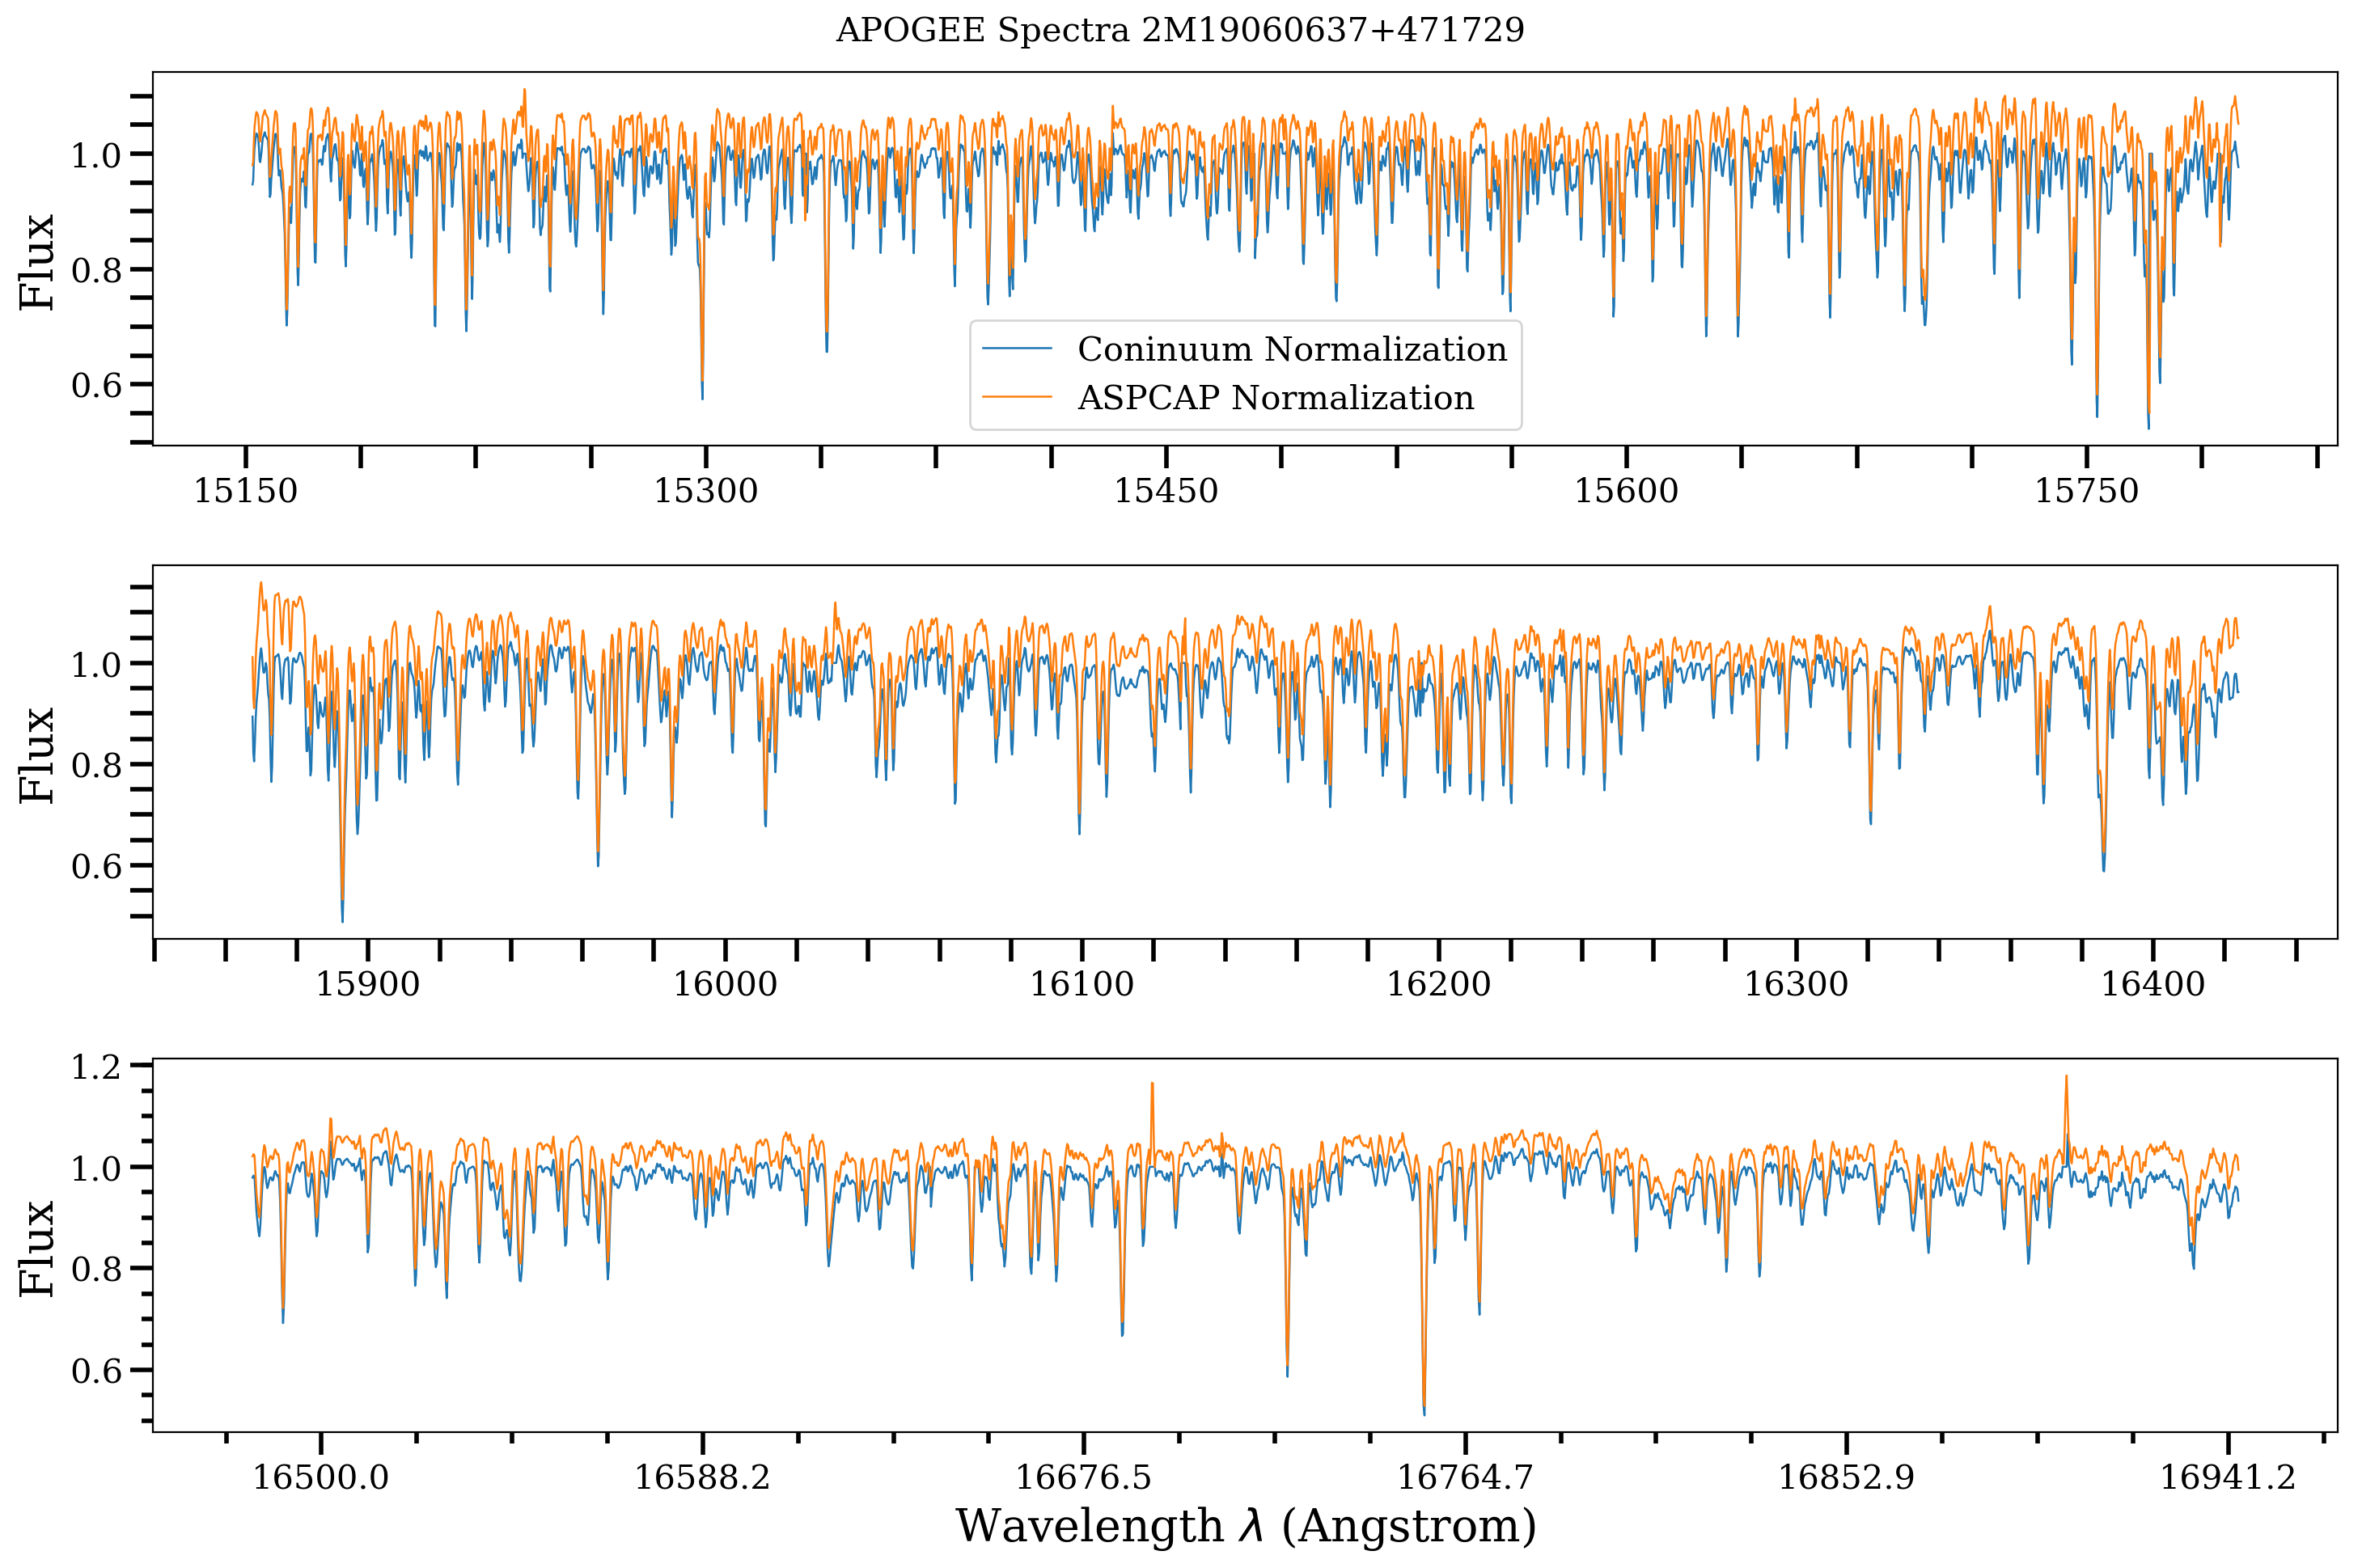

In [4]:
from astroNN.apogee import visit_spectra, combined_spectra, gap_delete, apogee_continuum, bitmask_boolean
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split
from astropy.io import fits 
import numpy as np
import pylab as plt

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
apstar_file = fits.open(visit_spectra(dr=14, location=4405, apogee="2M19060637+4717296", verbose=0))

# read the raw spectra from apstar
_spec = np.vstack((apstar_file[1].data, apstar_file[1].data))
_spec_err = np.vstack((apstar_file[2].data, apstar_file[2].data))
_spec_mask = np.vstack((apstar_file[3].data, apstar_file[3].data))

# delete gaps, normalize spectra and set target_bits in bitmask to 0
_spec = gap_delete(_spec, dr=14)
_spec_err = gap_delete(_spec_err, dr=14)
_spec_mask = gap_delete(_spec_mask, dr=14)
_normspec, _spec_err = apogee_continuum(_spec, _spec_err, bitmask=_spec_mask, target_bit=target_bit)

spec = gap_delete(fits.getdata(combined_spectra(dr=14, location=4405, apogee="2M19060637+4717296", verbose=0)))

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

fig = plt.figure(figsize=(15, 10), dpi=200)
blue, green, red = chips_split(_normspec[0], dr=14)
blue, green, red = blue[0], green[0], red[0]

aspcap_blue, aspcap_green, aspcap_red = chips_split(spec[0], dr=14)
aspcap_blue, aspcap_green, aspcap_red = aspcap_blue[0], aspcap_green[0], aspcap_red[0]

fig.suptitle('APOGEE Spectra 2M19060637+471729', fontsize=15)
ax1 = fig.add_subplot(311)
ax1.set_ylabel('Flux', fontsize=20)
ax1.plot(lambda_blue, blue, linewidth=0.9, label='Coninuum Normalization')
ax1.plot(lambda_blue, aspcap_blue, linewidth=0.9, label='ASPCAP Normalization')
ax2 = fig.add_subplot(312)
ax2.set_ylabel('Flux', fontsize=20)
ax2.plot(lambda_green, green, linewidth=0.9, label='astroNN')
ax2.plot(lambda_green, aspcap_green, linewidth=0.9, label='ASPCAP')
ax3 = fig.add_subplot(313)
ax3.set_ylabel('Flux', fontsize=20)
ax3.plot(lambda_red, red, linewidth=0.9, label='astroNN')
ax3.plot(lambda_red, aspcap_red, linewidth=0.9, label='ASPCAP')
ax3.set_xlabel(r'Wavelength $\lambda$ (Angstrom)', fontsize=20)
ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=10, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=10, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
tick_spacing = 150
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.7))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.98])
plt.savefig('normalization_aspcap.png')